In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.linear import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist, plot_data_values
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((0, 1))
        self.l_dim = 128
        self.remove_extreme = True
        # self.wsize = 5
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 200
        self.sample_interval = self.epochs // 2
        self.train_plots = True
        self.D_niters = 10
        self.G_niters = 5
        
        # create ouput dirs
        self.model_out = Path('./runs/linear/' + time_id)
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["linear", "joint", "minmax", "test"]
        self.desc = "Stacked Linear (batch norm G - init weights)"
        self.type = "Linear"
        
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=opts.remove_extreme,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=StandardScaler(),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]


In [3]:
# dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=640,
    output_size=dataset.inputs.shape[1],
    nlower=2,
    neg_slope=0.2
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=640,
    nlayers=1, 
    neg_slope=0.2
).to(device)

Using device:  cuda:0


In [5]:
netG.train()

Generator(
  (main): Sequential(
    (inl): Linear(in_features=1280, out_features=640, bias=True)
    (inleaky): LeakyReLU(negative_slope=0.2, inplace=True)
    (linl1): Linear(in_features=640, out_features=640, bias=True)
    (linleaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (linl2): Linear(in_features=640, out_features=640, bias=True)
    (linleaky2): LeakyReLU(negative_slope=0.2, inplace=True)
    (out): Linear(in_features=640, out_features=1280, bias=True)
  )
)

In [6]:
netD.train()

Discriminator(
  (main): Sequential(
    (in): Linear(in_features=1280, out_features=640, bias=True)
    (in_leaky): LeakyReLU(negative_slope=0.2, inplace=True)
    (l1): Linear(in_features=640, out_features=320, bias=True)
    (leaky1): LeakyReLU(negative_slope=0.2, inplace=True)
    (out): Linear(in_features=320, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [7]:
logger = Logger([netG, netD], opts.model_out / f"{time_id}.md", vars(opts))

# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.D_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.G_lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                            labels=["B [G]", "alpha [deg]"],
                            scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plt.close(fig)
    elif epoch % opts.sample_interval == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                            labels=["B [G]", "alpha [deg]"],
                            scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[0/200]	Loss_D: 0.1542	Loss_G: 3.8256	D(x): 0.8858	D(G(z)): 0.0312


Epoch [1/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[1/200]	Loss_D: 1.0904	Loss_G: 0.4753	D(x): 0.9515	D(G(z)): 0.6321


Epoch [2/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[2/200]	Loss_D: 0.4915	Loss_G: 1.2245	D(x): 0.9261	D(G(z)): 0.3184


Epoch [3/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[3/200]	Loss_D: 1.2160	Loss_G: 0.4434	D(x): 0.9005	D(G(z)): 0.6521


Epoch [4/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[4/200]	Loss_D: 1.6998	Loss_G: 0.2350	D(x): 0.9709	D(G(z)): 0.7950


Epoch [5/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[5/200]	Loss_D: 1.6377	Loss_G: 0.2635	D(x): 0.9378	D(G(z)): 0.7735


Epoch [6/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[6/200]	Loss_D: 1.1351	Loss_G: 0.4508	D(x): 0.9229	D(G(z)): 0.6429


Epoch [7/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[7/200]	Loss_D: 1.6908	Loss_G: 0.2455	D(x): 0.9130	D(G(z)): 0.7849


Epoch [8/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[8/200]	Loss_D: 1.8572	Loss_G: 0.2128	D(x): 0.8668	D(G(z)): 0.8100


Epoch [9/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[9/200]	Loss_D: 2.0221	Loss_G: 0.1740	D(x): 0.8919	D(G(z)): 0.8422


Epoch [10/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[10/200]	Loss_D: 2.3112	Loss_G: 0.1424	D(x): 0.8762	D(G(z)): 0.8688


Epoch [11/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[11/200]	Loss_D: 1.5849	Loss_G: 0.5074	D(x): 0.7332	D(G(z)): 0.6581


Epoch [12/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[12/200]	Loss_D: 2.3633	Loss_G: 0.1966	D(x): 0.9042	D(G(z)): 0.8476


Epoch [13/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[13/200]	Loss_D: 1.5331	Loss_G: 0.3787	D(x): 0.8110	D(G(z)): 0.6939


Epoch [14/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[14/200]	Loss_D: 1.4773	Loss_G: 0.4493	D(x): 0.8219	D(G(z)): 0.6721


Epoch [15/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[15/200]	Loss_D: 1.3994	Loss_G: 0.4852	D(x): 0.8508	D(G(z)): 0.6448


Epoch [16/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[16/200]	Loss_D: 1.9232	Loss_G: 0.2929	D(x): 0.8287	D(G(z)): 0.7648


Epoch [17/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[17/200]	Loss_D: 2.1565	Loss_G: 0.2572	D(x): 0.8764	D(G(z)): 0.7946


Epoch [18/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[18/200]	Loss_D: 1.4360	Loss_G: 0.4584	D(x): 0.8576	D(G(z)): 0.6639


Epoch [19/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[19/200]	Loss_D: 1.6314	Loss_G: 0.3736	D(x): 0.8733	D(G(z)): 0.7193


Epoch [20/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[20/200]	Loss_D: 1.9413	Loss_G: 0.2535	D(x): 0.8628	D(G(z)): 0.7874


Epoch [21/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[21/200]	Loss_D: 1.0477	Loss_G: 0.6259	D(x): 0.8847	D(G(z)): 0.5662


Epoch [22/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[22/200]	Loss_D: 1.2841	Loss_G: 0.5243	D(x): 0.9022	D(G(z)): 0.6247


Epoch [23/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[23/200]	Loss_D: 1.1213	Loss_G: 0.6522	D(x): 0.9036	D(G(z)): 0.5658


Epoch [24/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[24/200]	Loss_D: 1.5634	Loss_G: 0.3861	D(x): 0.9507	D(G(z)): 0.7090


Epoch [25/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[25/200]	Loss_D: 0.9872	Loss_G: 0.9089	D(x): 0.9002	D(G(z)): 0.4879


Epoch [26/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[26/200]	Loss_D: 1.3856	Loss_G: 0.5063	D(x): 0.9224	D(G(z)): 0.6553


Epoch [27/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[27/200]	Loss_D: 1.2119	Loss_G: 0.6740	D(x): 0.9165	D(G(z)): 0.5818


Epoch [28/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[28/200]	Loss_D: 1.0917	Loss_G: 0.7620	D(x): 0.9619	D(G(z)): 0.5628


Epoch [29/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[29/200]	Loss_D: 0.7383	Loss_G: 1.4923	D(x): 0.8983	D(G(z)): 0.3433


Epoch [30/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[30/200]	Loss_D: 1.4689	Loss_G: 0.4609	D(x): 0.9332	D(G(z)): 0.6835


Epoch [31/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[31/200]	Loss_D: 1.1691	Loss_G: 0.7430	D(x): 0.9069	D(G(z)): 0.5547


Epoch [32/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[32/200]	Loss_D: 1.7861	Loss_G: 0.3993	D(x): 0.9276	D(G(z)): 0.7202


Epoch [33/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[33/200]	Loss_D: 1.2100	Loss_G: 0.6118	D(x): 0.8366	D(G(z)): 0.5836


Epoch [34/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[34/200]	Loss_D: 2.1062	Loss_G: 0.3039	D(x): 0.9519	D(G(z)): 0.7674


Epoch [35/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[35/200]	Loss_D: 1.0514	Loss_G: 0.7206	D(x): 0.9396	D(G(z)): 0.5400


Epoch [36/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[36/200]	Loss_D: 0.7916	Loss_G: 1.1004	D(x): 0.9252	D(G(z)): 0.4231


Epoch [37/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[37/200]	Loss_D: 1.2643	Loss_G: 0.9931	D(x): 0.8954	D(G(z)): 0.5349


Epoch [38/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[38/200]	Loss_D: 0.9142	Loss_G: 0.8921	D(x): 0.9475	D(G(z)): 0.4882


Epoch [39/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[39/200]	Loss_D: 1.2424	Loss_G: 0.6846	D(x): 0.9362	D(G(z)): 0.5895


Epoch [40/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[40/200]	Loss_D: 1.2924	Loss_G: 0.4978	D(x): 0.9557	D(G(z)): 0.6535


Epoch [41/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[41/200]	Loss_D: 1.1334	Loss_G: 0.7931	D(x): 0.8513	D(G(z)): 0.5093


Epoch [42/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[42/200]	Loss_D: 1.0826	Loss_G: 0.8924	D(x): 0.8716	D(G(z)): 0.5061


Epoch [43/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[43/200]	Loss_D: 0.8772	Loss_G: 1.5159	D(x): 0.8509	D(G(z)): 0.3790


Epoch [44/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[44/200]	Loss_D: 0.8854	Loss_G: 0.9576	D(x): 0.8995	D(G(z)): 0.4637


Epoch [45/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[45/200]	Loss_D: 0.9659	Loss_G: 1.1216	D(x): 0.8844	D(G(z)): 0.4306


Epoch [46/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[46/200]	Loss_D: 0.8998	Loss_G: 0.9212	D(x): 0.9210	D(G(z)): 0.4839


Epoch [47/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[47/200]	Loss_D: 0.5608	Loss_G: 1.6746	D(x): 0.8692	D(G(z)): 0.2748


Epoch [48/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[48/200]	Loss_D: 0.7898	Loss_G: 1.2576	D(x): 0.7922	D(G(z)): 0.3489


Epoch [49/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[49/200]	Loss_D: 1.0737	Loss_G: 0.7257	D(x): 0.8820	D(G(z)): 0.5401


Epoch [50/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[50/200]	Loss_D: 1.3867	Loss_G: 0.6732	D(x): 0.8813	D(G(z)): 0.5997


Epoch [51/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[51/200]	Loss_D: 1.0207	Loss_G: 0.9762	D(x): 0.9266	D(G(z)): 0.4608


Epoch [52/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[52/200]	Loss_D: 0.3094	Loss_G: 2.4933	D(x): 0.8651	D(G(z)): 0.1116


Epoch [53/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[53/200]	Loss_D: 1.0544	Loss_G: 0.8765	D(x): 0.8798	D(G(z)): 0.5059


Epoch [54/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[54/200]	Loss_D: 0.7977	Loss_G: 1.0528	D(x): 0.8987	D(G(z)): 0.4355


Epoch [55/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[55/200]	Loss_D: 1.0115	Loss_G: 0.8615	D(x): 0.9549	D(G(z)): 0.5134


Epoch [56/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[56/200]	Loss_D: 1.0316	Loss_G: 0.8963	D(x): 0.9071	D(G(z)): 0.4929


Epoch [57/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[57/200]	Loss_D: 0.8291	Loss_G: 0.9203	D(x): 0.9199	D(G(z)): 0.4645


Epoch [58/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[58/200]	Loss_D: 0.7566	Loss_G: 1.0007	D(x): 0.9499	D(G(z)): 0.4406


Epoch [59/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[59/200]	Loss_D: 1.8900	Loss_G: 0.6800	D(x): 0.9747	D(G(z)): 0.6246


Epoch [60/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[60/200]	Loss_D: 0.3782	Loss_G: 2.2931	D(x): 0.8865	D(G(z)): 0.1835


Epoch [61/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[61/200]	Loss_D: 0.9563	Loss_G: 2.0465	D(x): 0.8722	D(G(z)): 0.4064


Epoch [62/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[62/200]	Loss_D: 0.5102	Loss_G: 2.3313	D(x): 0.8683	D(G(z)): 0.2221


Epoch [63/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[63/200]	Loss_D: 2.0054	Loss_G: 0.2714	D(x): 0.9570	D(G(z)): 0.7846


Epoch [64/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[64/200]	Loss_D: 0.8806	Loss_G: 0.9190	D(x): 0.9192	D(G(z)): 0.4728


Epoch [65/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[65/200]	Loss_D: 0.4166	Loss_G: 2.1900	D(x): 0.9058	D(G(z)): 0.1995


Epoch [66/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[66/200]	Loss_D: 0.8926	Loss_G: 1.1840	D(x): 0.9084	D(G(z)): 0.4369


Epoch [67/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[67/200]	Loss_D: 1.5550	Loss_G: 0.9414	D(x): 0.9211	D(G(z)): 0.6183


Epoch [68/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[68/200]	Loss_D: 1.5089	Loss_G: 0.5992	D(x): 0.9255	D(G(z)): 0.6296


Epoch [69/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[69/200]	Loss_D: 1.7183	Loss_G: 0.3804	D(x): 0.9313	D(G(z)): 0.7244


Epoch [70/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[70/200]	Loss_D: 0.8756	Loss_G: 1.0835	D(x): 0.9255	D(G(z)): 0.4288


Epoch [71/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[71/200]	Loss_D: 0.6461	Loss_G: 1.2709	D(x): 0.9438	D(G(z)): 0.3715


Epoch [72/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[72/200]	Loss_D: 1.4678	Loss_G: 0.7312	D(x): 0.9468	D(G(z)): 0.6090


Epoch [73/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[73/200]	Loss_D: 0.7941	Loss_G: 1.0485	D(x): 0.8882	D(G(z)): 0.4273


Epoch [74/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[74/200]	Loss_D: 1.4641	Loss_G: 0.8231	D(x): 0.9294	D(G(z)): 0.6070


Epoch [75/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[75/200]	Loss_D: 0.8379	Loss_G: 1.2346	D(x): 0.9474	D(G(z)): 0.4109


Epoch [76/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[76/200]	Loss_D: 2.1635	Loss_G: 0.2451	D(x): 0.9690	D(G(z)): 0.8025


Epoch [77/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[77/200]	Loss_D: 1.4648	Loss_G: 0.5144	D(x): 0.9351	D(G(z)): 0.6573


Epoch [78/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[78/200]	Loss_D: 1.4812	Loss_G: 0.7531	D(x): 0.9164	D(G(z)): 0.6382


Epoch [79/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[79/200]	Loss_D: 1.7606	Loss_G: 0.2768	D(x): 0.9664	D(G(z)): 0.7736


Epoch [80/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[80/200]	Loss_D: 0.5910	Loss_G: 1.7665	D(x): 0.9076	D(G(z)): 0.2863


Epoch [81/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[81/200]	Loss_D: 0.5106	Loss_G: 2.0052	D(x): 0.9219	D(G(z)): 0.2665


Epoch [82/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[82/200]	Loss_D: 1.6585	Loss_G: 0.4927	D(x): 0.9738	D(G(z)): 0.6846


Epoch [83/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[83/200]	Loss_D: 0.8443	Loss_G: 1.1374	D(x): 0.8993	D(G(z)): 0.4229


Epoch [84/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[84/200]	Loss_D: 0.8370	Loss_G: 1.0268	D(x): 0.9355	D(G(z)): 0.4418


Epoch [85/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[85/200]	Loss_D: 0.5011	Loss_G: 1.3770	D(x): 0.9527	D(G(z)): 0.3257


Epoch [86/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[86/200]	Loss_D: 1.4964	Loss_G: 0.6123	D(x): 0.9667	D(G(z)): 0.6391


Epoch [87/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[87/200]	Loss_D: 0.7509	Loss_G: 1.0377	D(x): 0.9763	D(G(z)): 0.4450


Epoch [88/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[88/200]	Loss_D: 1.1449	Loss_G: 1.0884	D(x): 0.9367	D(G(z)): 0.5172


Epoch [89/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[89/200]	Loss_D: 1.4693	Loss_G: 0.4761	D(x): 0.9188	D(G(z)): 0.6692


Epoch [90/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[90/200]	Loss_D: 1.0564	Loss_G: 0.8049	D(x): 0.9210	D(G(z)): 0.5389


Epoch [91/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[91/200]	Loss_D: 0.6770	Loss_G: 1.3977	D(x): 0.9534	D(G(z)): 0.3758


Epoch [92/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[92/200]	Loss_D: 0.6402	Loss_G: 1.5165	D(x): 0.8726	D(G(z)): 0.3057


Epoch [93/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[93/200]	Loss_D: 1.1872	Loss_G: 0.7316	D(x): 0.9642	D(G(z)): 0.5990


Epoch [94/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[94/200]	Loss_D: 0.2979	Loss_G: 2.3710	D(x): 0.9440	D(G(z)): 0.1877


Epoch [95/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[95/200]	Loss_D: 2.2186	Loss_G: 0.2419	D(x): 0.9783	D(G(z)): 0.8153


Epoch [96/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[96/200]	Loss_D: 0.9188	Loss_G: 1.0262	D(x): 0.9741	D(G(z)): 0.4873


Epoch [97/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[97/200]	Loss_D: 0.8243	Loss_G: 1.0967	D(x): 0.9445	D(G(z)): 0.4440


Epoch [98/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[98/200]	Loss_D: 1.3768	Loss_G: 0.5601	D(x): 0.9126	D(G(z)): 0.6289


Epoch [99/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[99/200]	Loss_D: 0.3756	Loss_G: 2.4669	D(x): 0.9028	D(G(z)): 0.1858


Epoch [100/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[100/200]	Loss_D: 0.5898	Loss_G: 1.7565	D(x): 0.9180	D(G(z)): 0.3240


Epoch [101/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[101/200]	Loss_D: 1.2793	Loss_G: 0.5841	D(x): 0.9539	D(G(z)): 0.6155


Epoch [102/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[102/200]	Loss_D: 0.8695	Loss_G: 1.2697	D(x): 0.9456	D(G(z)): 0.4333


Epoch [103/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[103/200]	Loss_D: 0.5446	Loss_G: 1.5834	D(x): 0.9602	D(G(z)): 0.3180


Epoch [104/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[104/200]	Loss_D: 0.9797	Loss_G: 1.2337	D(x): 0.9589	D(G(z)): 0.4808


Epoch [105/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[105/200]	Loss_D: 3.0268	Loss_G: 0.1254	D(x): 0.9573	D(G(z)): 0.8942


Epoch [106/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[106/200]	Loss_D: 1.0518	Loss_G: 0.7745	D(x): 0.9507	D(G(z)): 0.5552


Epoch [107/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[107/200]	Loss_D: 1.8653	Loss_G: 0.3870	D(x): 0.9763	D(G(z)): 0.7404


Epoch [108/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[108/200]	Loss_D: 1.6521	Loss_G: 0.4044	D(x): 0.9214	D(G(z)): 0.7139


Epoch [109/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[109/200]	Loss_D: 1.2546	Loss_G: 0.8006	D(x): 0.8952	D(G(z)): 0.5368


Epoch [110/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[110/200]	Loss_D: 1.3899	Loss_G: 0.5580	D(x): 0.9423	D(G(z)): 0.6700


Epoch [111/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[111/200]	Loss_D: 0.4690	Loss_G: 1.7466	D(x): 0.9357	D(G(z)): 0.2782


Epoch [112/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[112/200]	Loss_D: 0.5058	Loss_G: 1.7813	D(x): 0.8744	D(G(z)): 0.2571


Epoch [113/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[113/200]	Loss_D: 2.0531	Loss_G: 0.3367	D(x): 0.9201	D(G(z)): 0.7659


Epoch [114/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[114/200]	Loss_D: 2.4825	Loss_G: 0.2190	D(x): 0.9266	D(G(z)): 0.8264


Epoch [115/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[115/200]	Loss_D: 1.1351	Loss_G: 0.7415	D(x): 0.9399	D(G(z)): 0.5625


Epoch [116/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[116/200]	Loss_D: 0.3943	Loss_G: 2.5788	D(x): 0.8765	D(G(z)): 0.1690


Epoch [117/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[117/200]	Loss_D: 0.3808	Loss_G: 3.1635	D(x): 0.8488	D(G(z)): 0.1502


Epoch [118/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[118/200]	Loss_D: 1.0886	Loss_G: 0.8680	D(x): 0.9580	D(G(z)): 0.5576


Epoch [119/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[119/200]	Loss_D: 0.7893	Loss_G: 1.1151	D(x): 0.9294	D(G(z)): 0.4375


Epoch [120/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[120/200]	Loss_D: 1.0082	Loss_G: 0.8197	D(x): 0.9479	D(G(z)): 0.5142


Epoch [121/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[121/200]	Loss_D: 1.2196	Loss_G: 0.7680	D(x): 0.9512	D(G(z)): 0.5484


Epoch [122/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[122/200]	Loss_D: 1.3115	Loss_G: 0.7167	D(x): 0.9483	D(G(z)): 0.6035


Epoch [123/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[123/200]	Loss_D: 0.6801	Loss_G: 1.2859	D(x): 0.9144	D(G(z)): 0.3678


Epoch [124/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[124/200]	Loss_D: 1.9994	Loss_G: 0.3180	D(x): 0.9474	D(G(z)): 0.7652


Epoch [125/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[125/200]	Loss_D: 1.1638	Loss_G: 0.7304	D(x): 0.9753	D(G(z)): 0.5764


Epoch [126/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[126/200]	Loss_D: 1.4318	Loss_G: 0.7472	D(x): 0.9603	D(G(z)): 0.6105


Epoch [127/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[127/200]	Loss_D: 0.7275	Loss_G: 1.4744	D(x): 0.8957	D(G(z)): 0.3631


Epoch [128/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[128/200]	Loss_D: 0.6372	Loss_G: 2.8422	D(x): 0.9583	D(G(z)): 0.2440


Epoch [129/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[129/200]	Loss_D: 0.7812	Loss_G: 1.4862	D(x): 0.9189	D(G(z)): 0.3621


Epoch [130/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[130/200]	Loss_D: 1.6676	Loss_G: 0.6365	D(x): 0.9477	D(G(z)): 0.6731


Epoch [131/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[131/200]	Loss_D: 0.8891	Loss_G: 0.9806	D(x): 0.9564	D(G(z)): 0.4638


Epoch [132/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[132/200]	Loss_D: 0.7612	Loss_G: 1.1992	D(x): 0.9617	D(G(z)): 0.4184


Epoch [133/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[133/200]	Loss_D: 1.8695	Loss_G: 0.3032	D(x): 0.9541	D(G(z)): 0.7689


Epoch [134/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[134/200]	Loss_D: 0.6741	Loss_G: 1.6788	D(x): 0.9024	D(G(z)): 0.3174


Epoch [135/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[135/200]	Loss_D: 2.1734	Loss_G: 0.2302	D(x): 0.9484	D(G(z)): 0.8187


Epoch [136/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[136/200]	Loss_D: 0.2268	Loss_G: 4.6489	D(x): 0.8805	D(G(z)): 0.0535


Epoch [137/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[137/200]	Loss_D: 0.4597	Loss_G: 2.7859	D(x): 0.9003	D(G(z)): 0.1830


Epoch [138/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[138/200]	Loss_D: 0.9669	Loss_G: 1.2258	D(x): 0.9536	D(G(z)): 0.4593


Epoch [139/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[139/200]	Loss_D: 0.8680	Loss_G: 1.2663	D(x): 0.9365	D(G(z)): 0.4326


Epoch [140/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[140/200]	Loss_D: 1.7665	Loss_G: 0.3785	D(x): 0.9525	D(G(z)): 0.7301


Epoch [141/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[141/200]	Loss_D: 0.6505	Loss_G: 1.3457	D(x): 0.9509	D(G(z)): 0.3786


Epoch [142/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[142/200]	Loss_D: 1.7244	Loss_G: 0.5188	D(x): 0.8991	D(G(z)): 0.7254


Epoch [143/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[143/200]	Loss_D: 0.6494	Loss_G: 1.7147	D(x): 0.9710	D(G(z)): 0.3372


Epoch [144/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[144/200]	Loss_D: 1.8955	Loss_G: 0.4334	D(x): 0.9790	D(G(z)): 0.7302


Epoch [145/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[145/200]	Loss_D: 0.8827	Loss_G: 0.8607	D(x): 0.9634	D(G(z)): 0.4932


Epoch [146/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[146/200]	Loss_D: 0.4156	Loss_G: 2.3665	D(x): 0.9068	D(G(z)): 0.2178


Epoch [147/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[147/200]	Loss_D: 1.7918	Loss_G: 0.4602	D(x): 0.9546	D(G(z)): 0.7049


Epoch [148/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[148/200]	Loss_D: 0.5708	Loss_G: 1.8128	D(x): 0.9341	D(G(z)): 0.3069


Epoch [149/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[149/200]	Loss_D: 0.8419	Loss_G: 1.3496	D(x): 0.9065	D(G(z)): 0.3857


Epoch [150/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[150/200]	Loss_D: 1.6339	Loss_G: 0.6325	D(x): 0.9541	D(G(z)): 0.6733


Epoch [151/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[151/200]	Loss_D: 1.1888	Loss_G: 0.6745	D(x): 0.9550	D(G(z)): 0.5814


Epoch [152/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[152/200]	Loss_D: 1.0073	Loss_G: 0.9104	D(x): 0.9577	D(G(z)): 0.5073


Epoch [153/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[153/200]	Loss_D: 0.8182	Loss_G: 1.2429	D(x): 0.8479	D(G(z)): 0.3957


Epoch [154/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[154/200]	Loss_D: 0.4641	Loss_G: 2.4134	D(x): 0.9400	D(G(z)): 0.2190


Epoch [155/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[155/200]	Loss_D: 1.3431	Loss_G: 0.7079	D(x): 0.8873	D(G(z)): 0.5830


Epoch [156/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[156/200]	Loss_D: 0.8788	Loss_G: 1.7358	D(x): 0.9453	D(G(z)): 0.3693


Epoch [157/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[157/200]	Loss_D: 0.3879	Loss_G: 2.6075	D(x): 0.9412	D(G(z)): 0.1892


Epoch [158/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[158/200]	Loss_D: 0.7772	Loss_G: 1.5012	D(x): 0.9482	D(G(z)): 0.3843


Epoch [159/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[159/200]	Loss_D: 0.9020	Loss_G: 1.1530	D(x): 0.9523	D(G(z)): 0.4503


Epoch [160/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[160/200]	Loss_D: 1.0908	Loss_G: 1.0522	D(x): 0.9411	D(G(z)): 0.4896


Epoch [161/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[161/200]	Loss_D: 1.5792	Loss_G: 0.4437	D(x): 0.9493	D(G(z)): 0.6956


Epoch [162/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[162/200]	Loss_D: 0.2929	Loss_G: 2.5129	D(x): 0.9261	D(G(z)): 0.1575


Epoch [163/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[163/200]	Loss_D: 0.5772	Loss_G: 1.6483	D(x): 0.9323	D(G(z)): 0.3199


Epoch [164/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[164/200]	Loss_D: 1.3438	Loss_G: 0.6424	D(x): 0.9510	D(G(z)): 0.6098


Epoch [165/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[165/200]	Loss_D: 1.0740	Loss_G: 0.8506	D(x): 0.9598	D(G(z)): 0.5473


Epoch [166/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[166/200]	Loss_D: 1.3455	Loss_G: 0.5788	D(x): 0.9199	D(G(z)): 0.6315


Epoch [167/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[167/200]	Loss_D: 1.1216	Loss_G: 0.7161	D(x): 0.9566	D(G(z)): 0.5564


Epoch [168/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[168/200]	Loss_D: 1.7281	Loss_G: 0.5042	D(x): 0.9450	D(G(z)): 0.6748


Epoch [169/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[169/200]	Loss_D: 1.6980	Loss_G: 0.6982	D(x): 0.9599	D(G(z)): 0.6568


Epoch [170/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[170/200]	Loss_D: 0.4071	Loss_G: 2.4028	D(x): 0.9154	D(G(z)): 0.1918


Epoch [171/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[171/200]	Loss_D: 1.3345	Loss_G: 0.9515	D(x): 0.9737	D(G(z)): 0.5577


Epoch [172/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[172/200]	Loss_D: 0.4528	Loss_G: 2.5751	D(x): 0.9065	D(G(z)): 0.1925


Epoch [173/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[173/200]	Loss_D: 1.2822	Loss_G: 0.6514	D(x): 0.9495	D(G(z)): 0.6045


Epoch [174/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[174/200]	Loss_D: 2.7208	Loss_G: 0.2437	D(x): 0.9672	D(G(z)): 0.8463


Epoch [175/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[175/200]	Loss_D: 0.8945	Loss_G: 1.5910	D(x): 0.8863	D(G(z)): 0.3468


Epoch [176/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[176/200]	Loss_D: 1.0915	Loss_G: 0.9664	D(x): 0.9717	D(G(z)): 0.4928


Epoch [177/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[177/200]	Loss_D: 0.9632	Loss_G: 1.1367	D(x): 0.9470	D(G(z)): 0.4868


Epoch [178/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[178/200]	Loss_D: 1.9338	Loss_G: 0.4485	D(x): 0.9803	D(G(z)): 0.7221


Epoch [179/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[179/200]	Loss_D: 0.6984	Loss_G: 1.7572	D(x): 0.9756	D(G(z)): 0.3460


Epoch [180/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[180/200]	Loss_D: 2.2732	Loss_G: 0.1643	D(x): 0.9496	D(G(z)): 0.8547


Epoch [181/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[181/200]	Loss_D: 0.4877	Loss_G: 2.1170	D(x): 0.9676	D(G(z)): 0.2668


Epoch [182/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[182/200]	Loss_D: 1.6599	Loss_G: 0.4420	D(x): 0.9546	D(G(z)): 0.7159


Epoch [183/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[183/200]	Loss_D: 0.7967	Loss_G: 1.4785	D(x): 0.9512	D(G(z)): 0.3866


Epoch [184/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[184/200]	Loss_D: 0.8286	Loss_G: 1.3086	D(x): 0.9387	D(G(z)): 0.4388


Epoch [185/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[185/200]	Loss_D: 0.9008	Loss_G: 1.4761	D(x): 0.8890	D(G(z)): 0.4059


Epoch [186/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[186/200]	Loss_D: 0.3808	Loss_G: 2.4016	D(x): 0.9431	D(G(z)): 0.2063


Epoch [187/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[187/200]	Loss_D: 1.5310	Loss_G: 0.5517	D(x): 0.9405	D(G(z)): 0.6672


Epoch [188/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[188/200]	Loss_D: 0.3081	Loss_G: 2.6999	D(x): 0.9620	D(G(z)): 0.1801


Epoch [189/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[189/200]	Loss_D: 1.1909	Loss_G: 0.8195	D(x): 0.9540	D(G(z)): 0.5519


Epoch [190/200]:   0%|          | 0/87 [00:00<?, ?it/s]

[190/200]	Loss_D: 0.6884	Loss_G: 1.6881	D(x): 0.9106	D(G(z)): 0.3719


Epoch [191/200]:   0%|          | 0/87 [00:00<?, ?it/s]

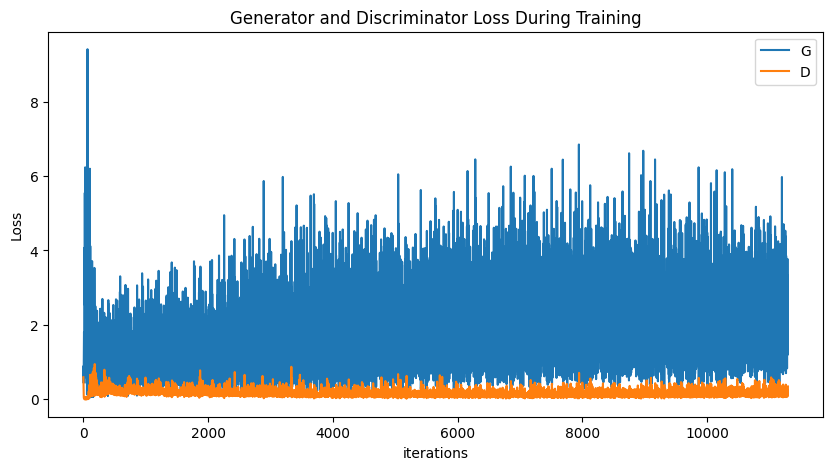

In [ ]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [ ]:

# netD.train(True)
# netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/multi/0313-1135_w20_madgan_pca320")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [ ]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[0.25825445 0.25848101 0.25870853 ... 0.         0.         0.        ]
 [0.26357888 0.2638036  0.26402926 ... 0.         0.         0.        ]
 [0.27695434 0.27718189 0.27741038 ... 0.         0.         0.        ]
 [0.25461553 0.25483148 0.25504835 ... 0.         0.         0.        ]
 [0.27191478 0.27212993 0.27234597 ... 0.         0.         0.        ]]


## Discriminator Classification

In [ ]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.13495373725891113
Found 1177 anomalies


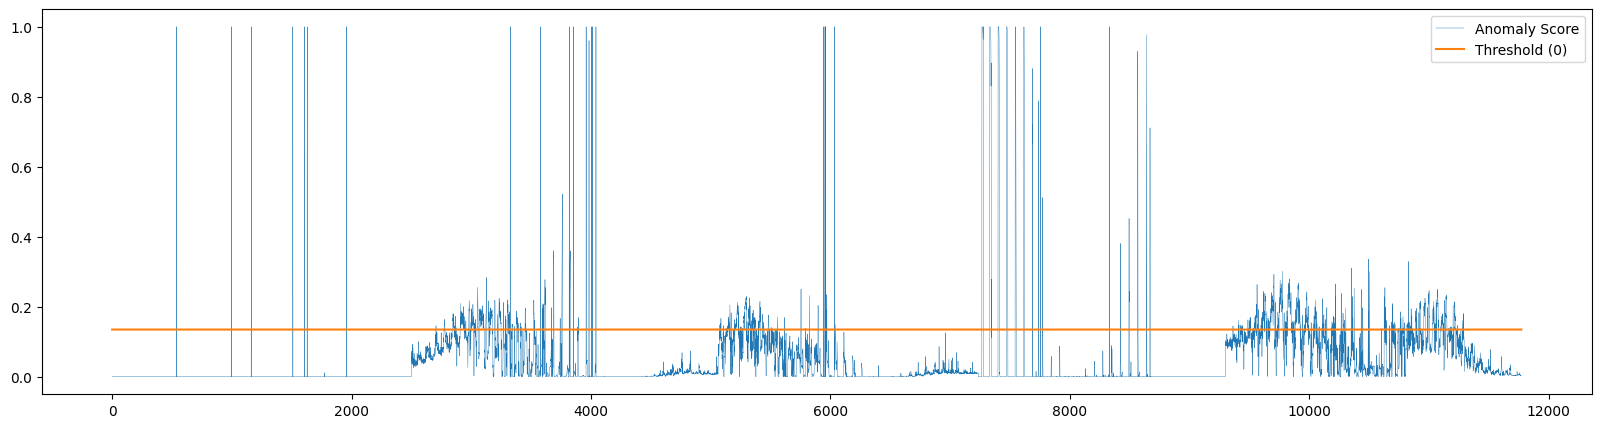

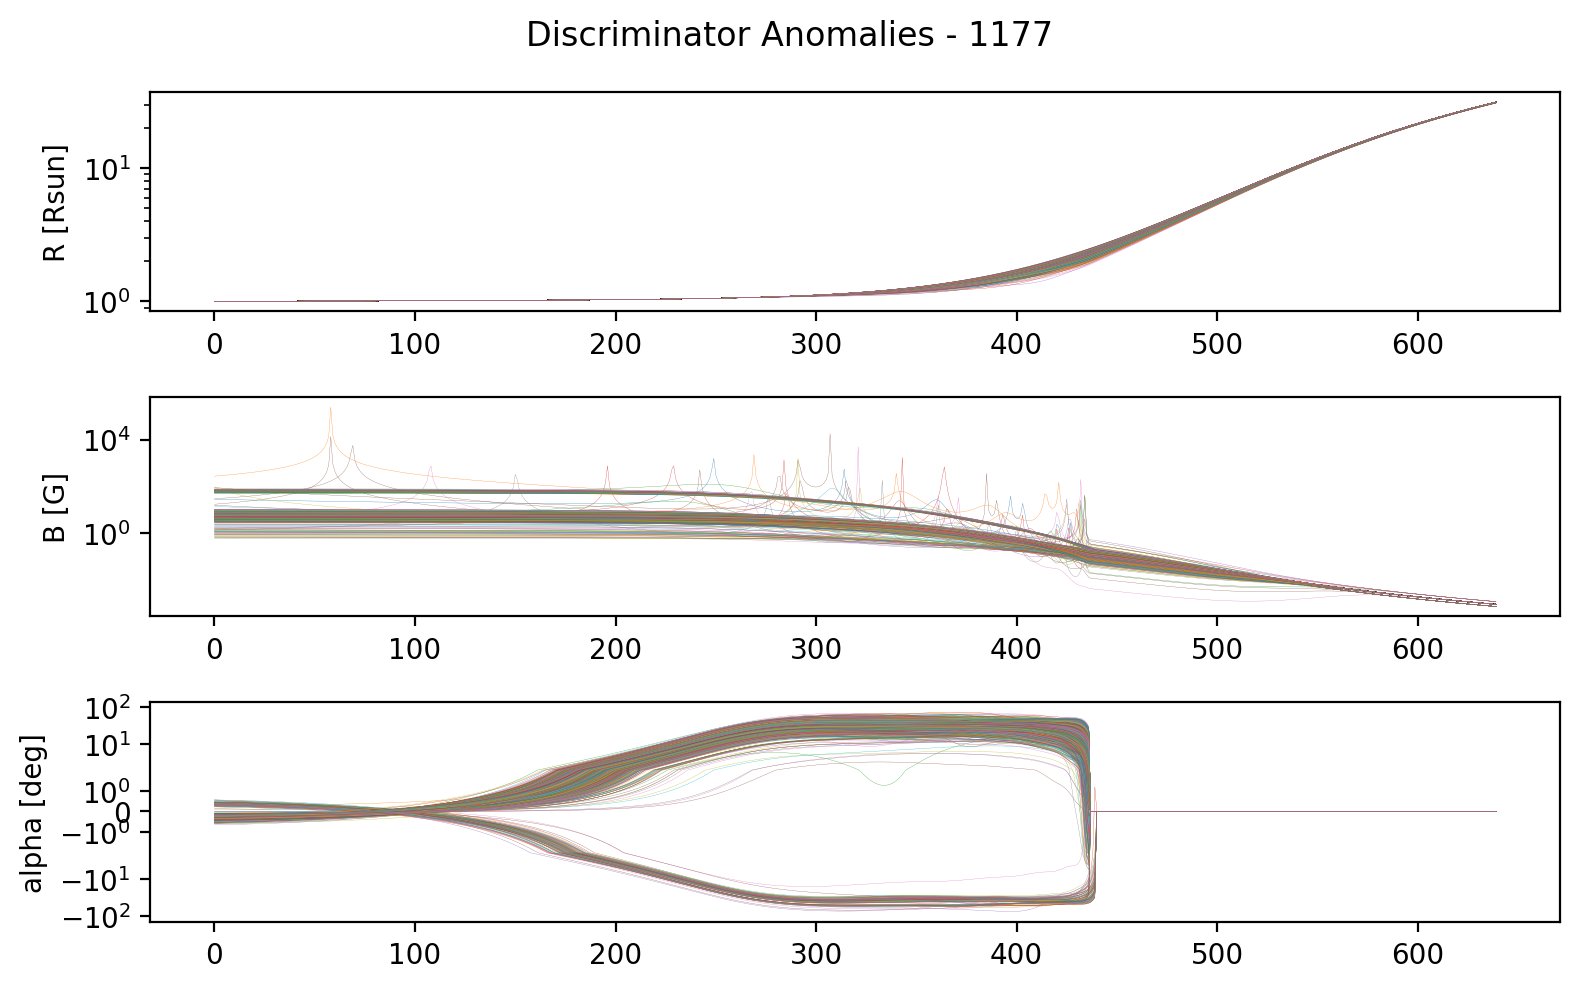

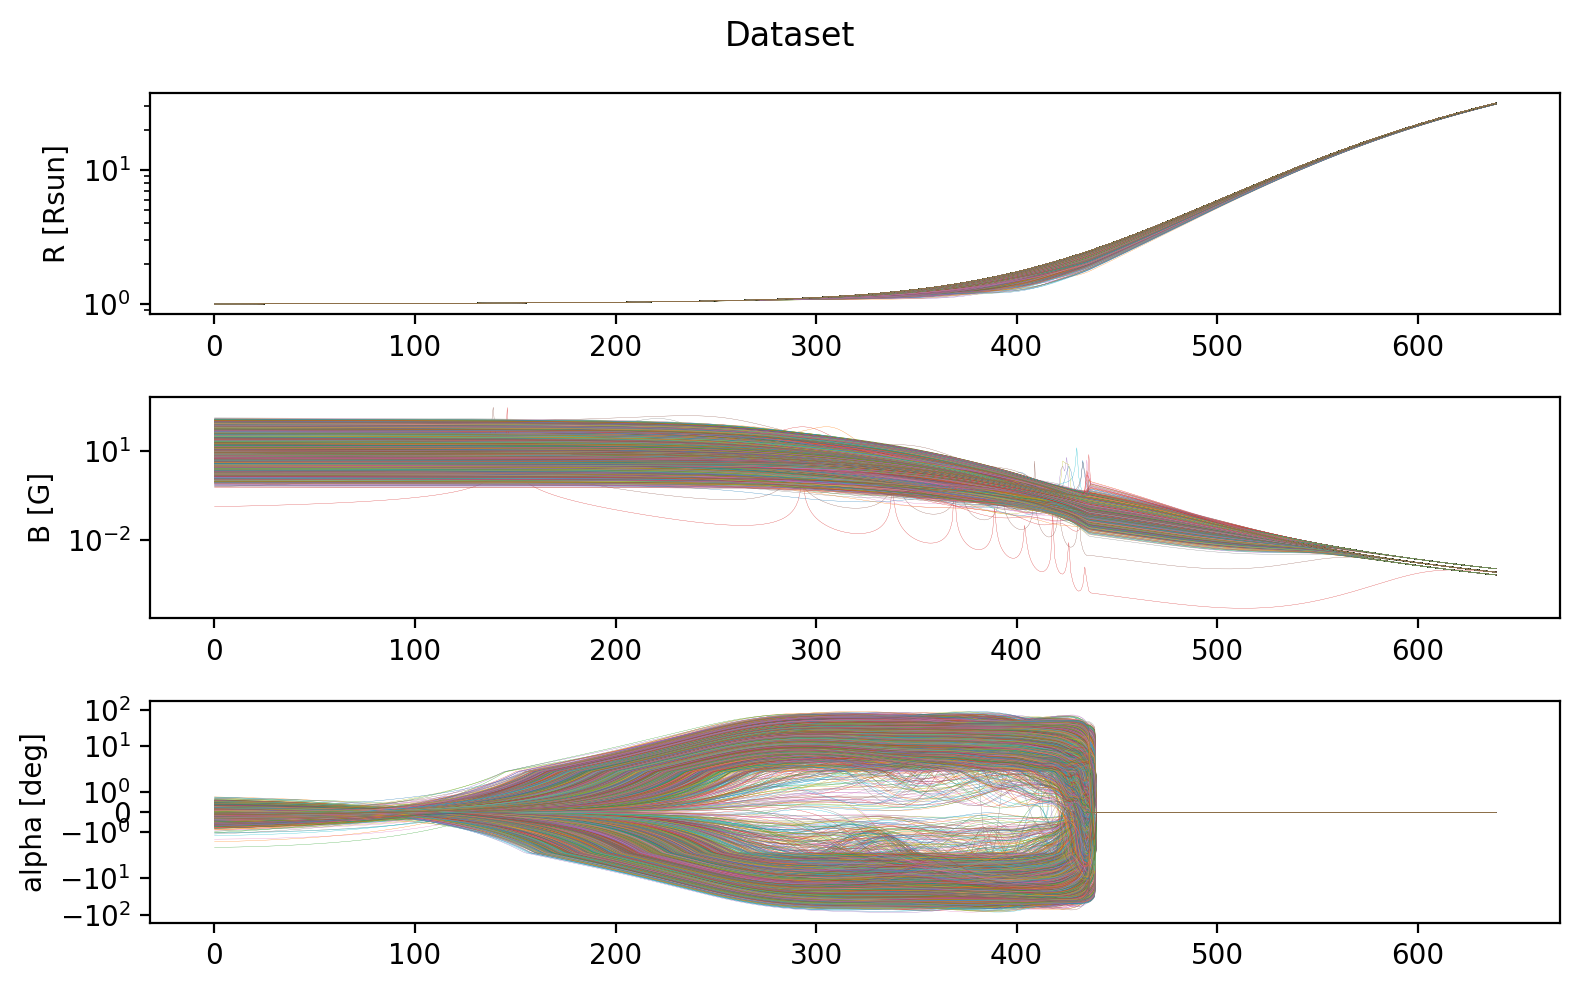

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="linear", method="Discriminator", normal_plot=True)

## Reconstruction Based

In [ ]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        # print(loss.shape)
        mse_scores.extend(zip(filenames, [l.mean().detach().cpu().numpy() for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [ ]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  0.01318706
Found 941 anomalies


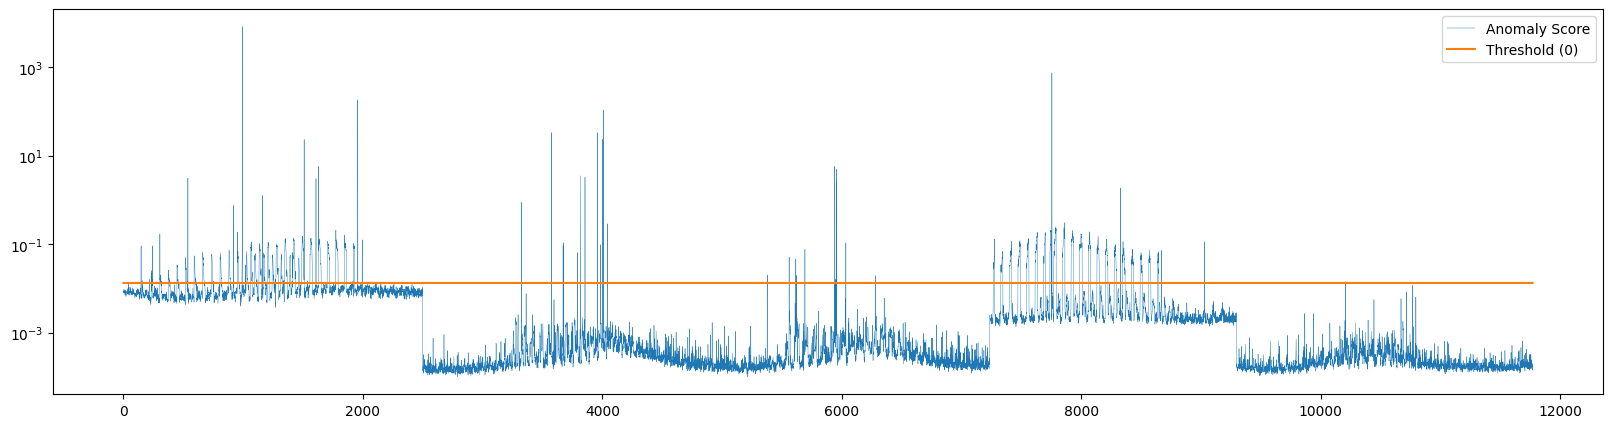

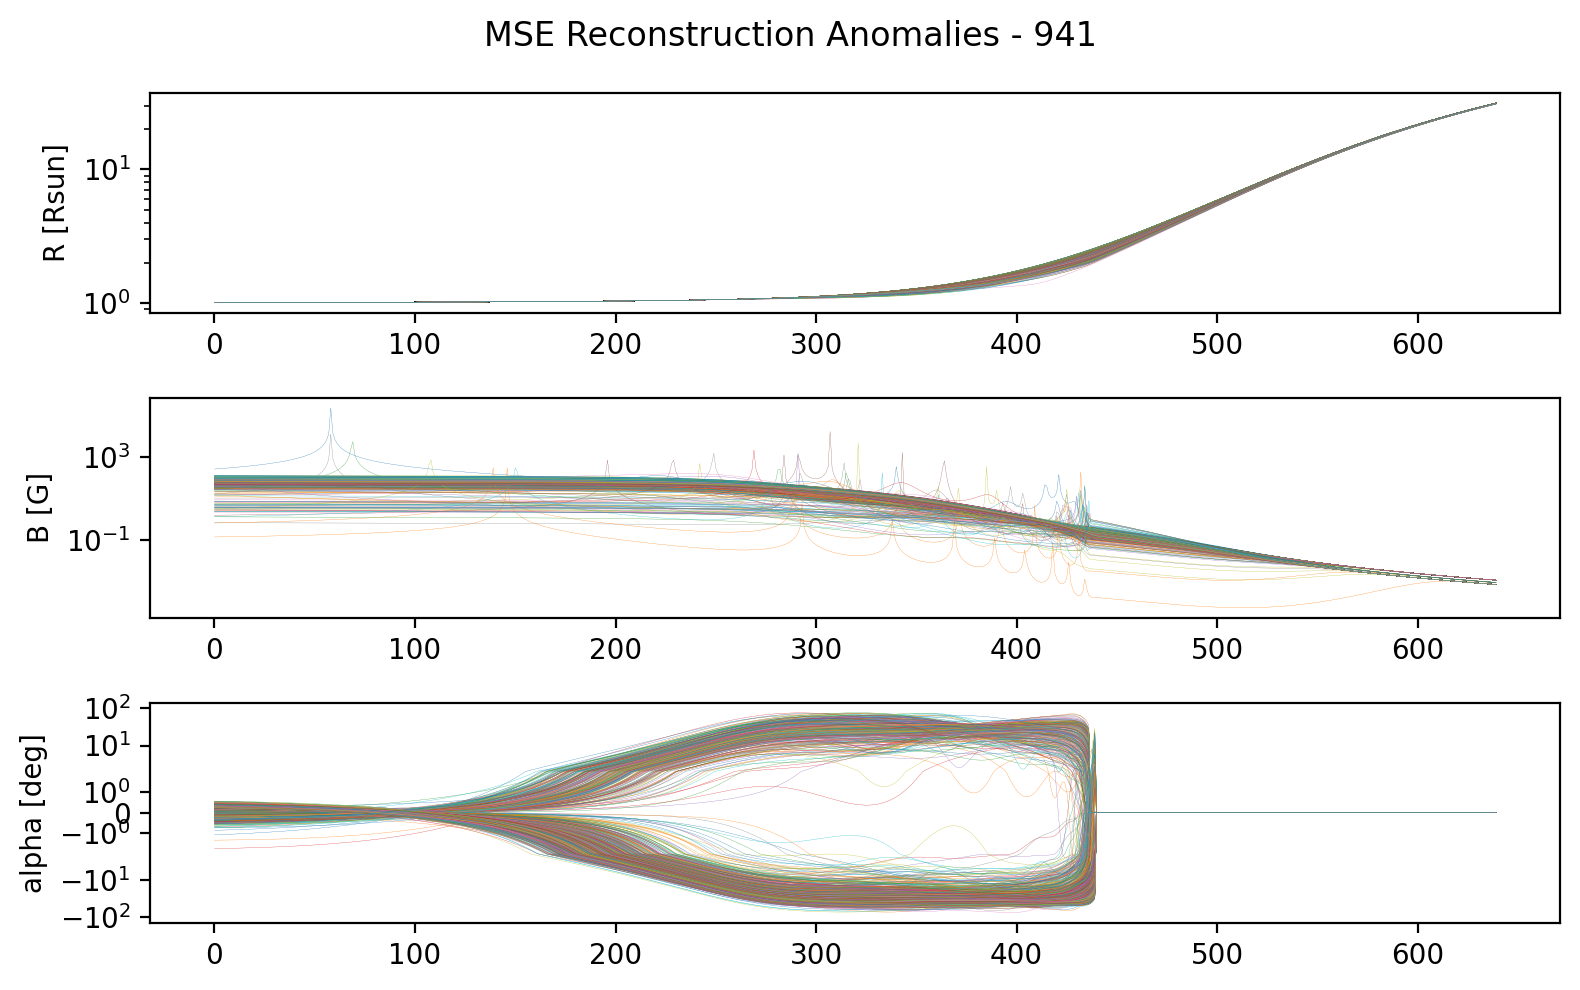

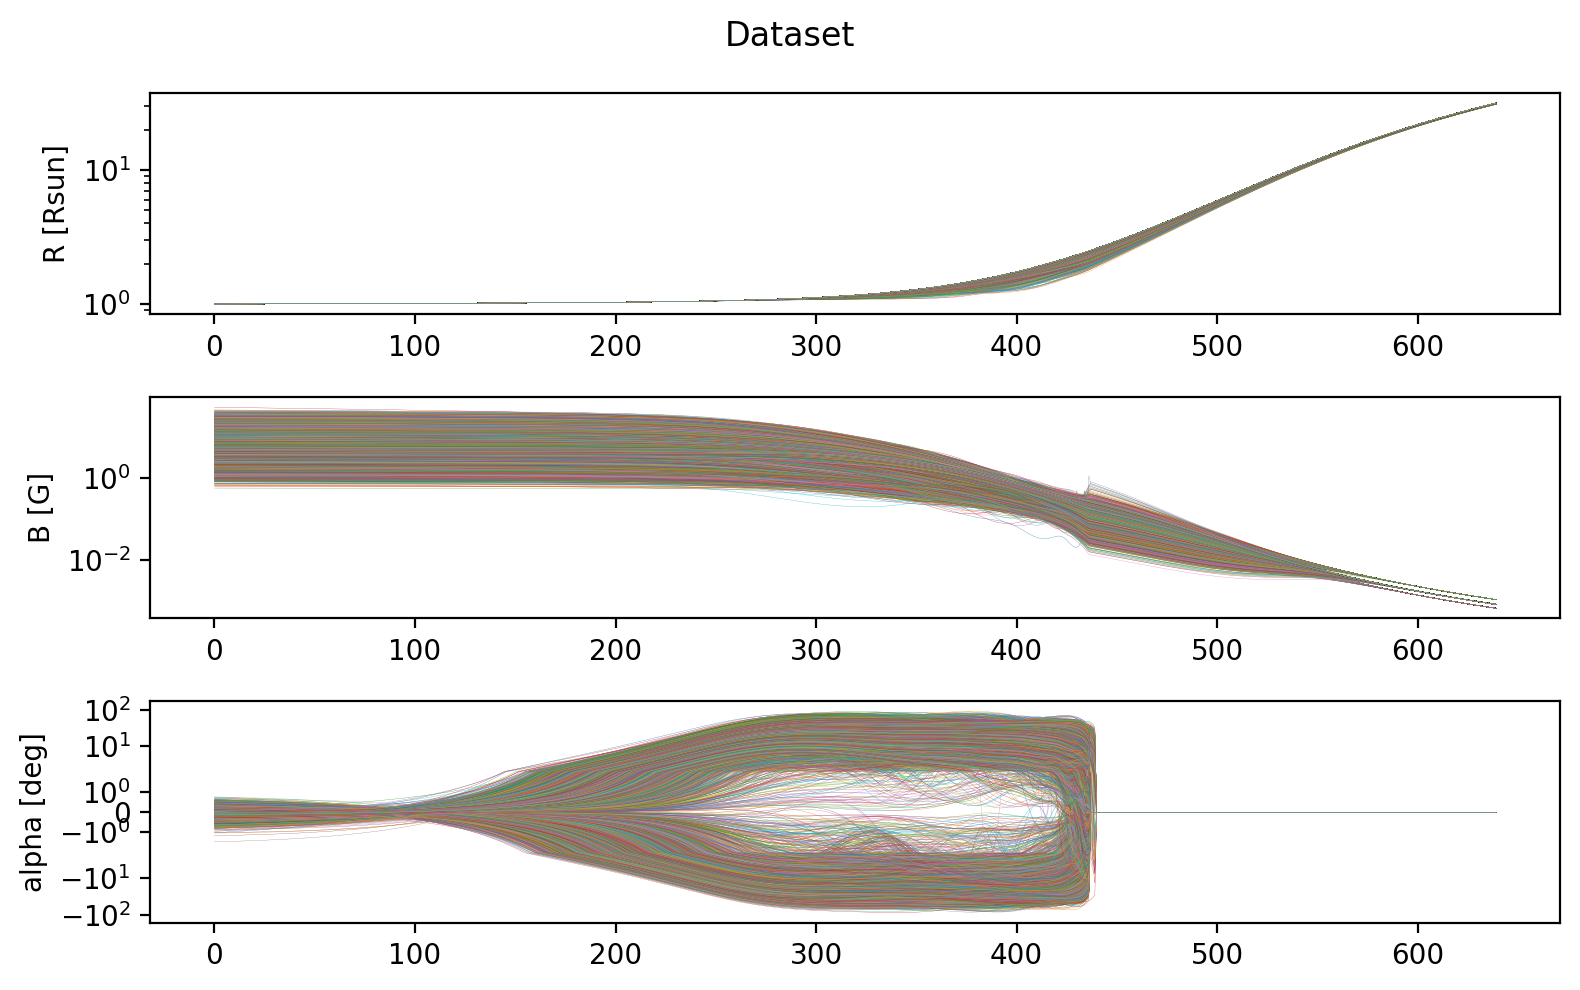

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.08, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE Reconstruction", normal_plot=True)

### MSE Reconstruction with Discriminator feedback

In [ ]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  4.807271e-06
Found 1177 anomalies


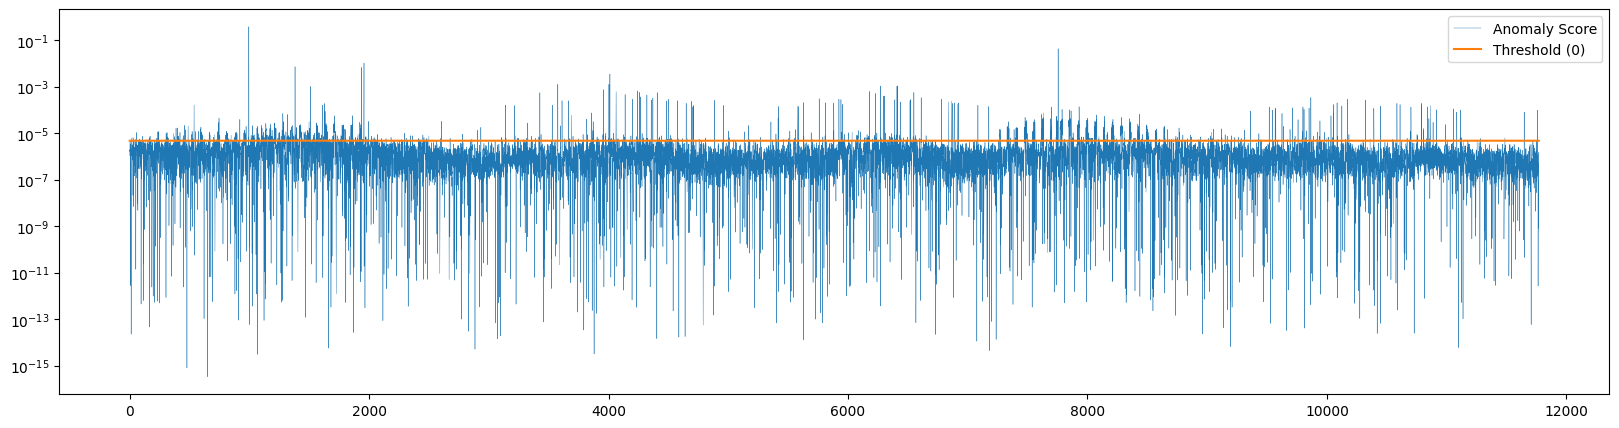

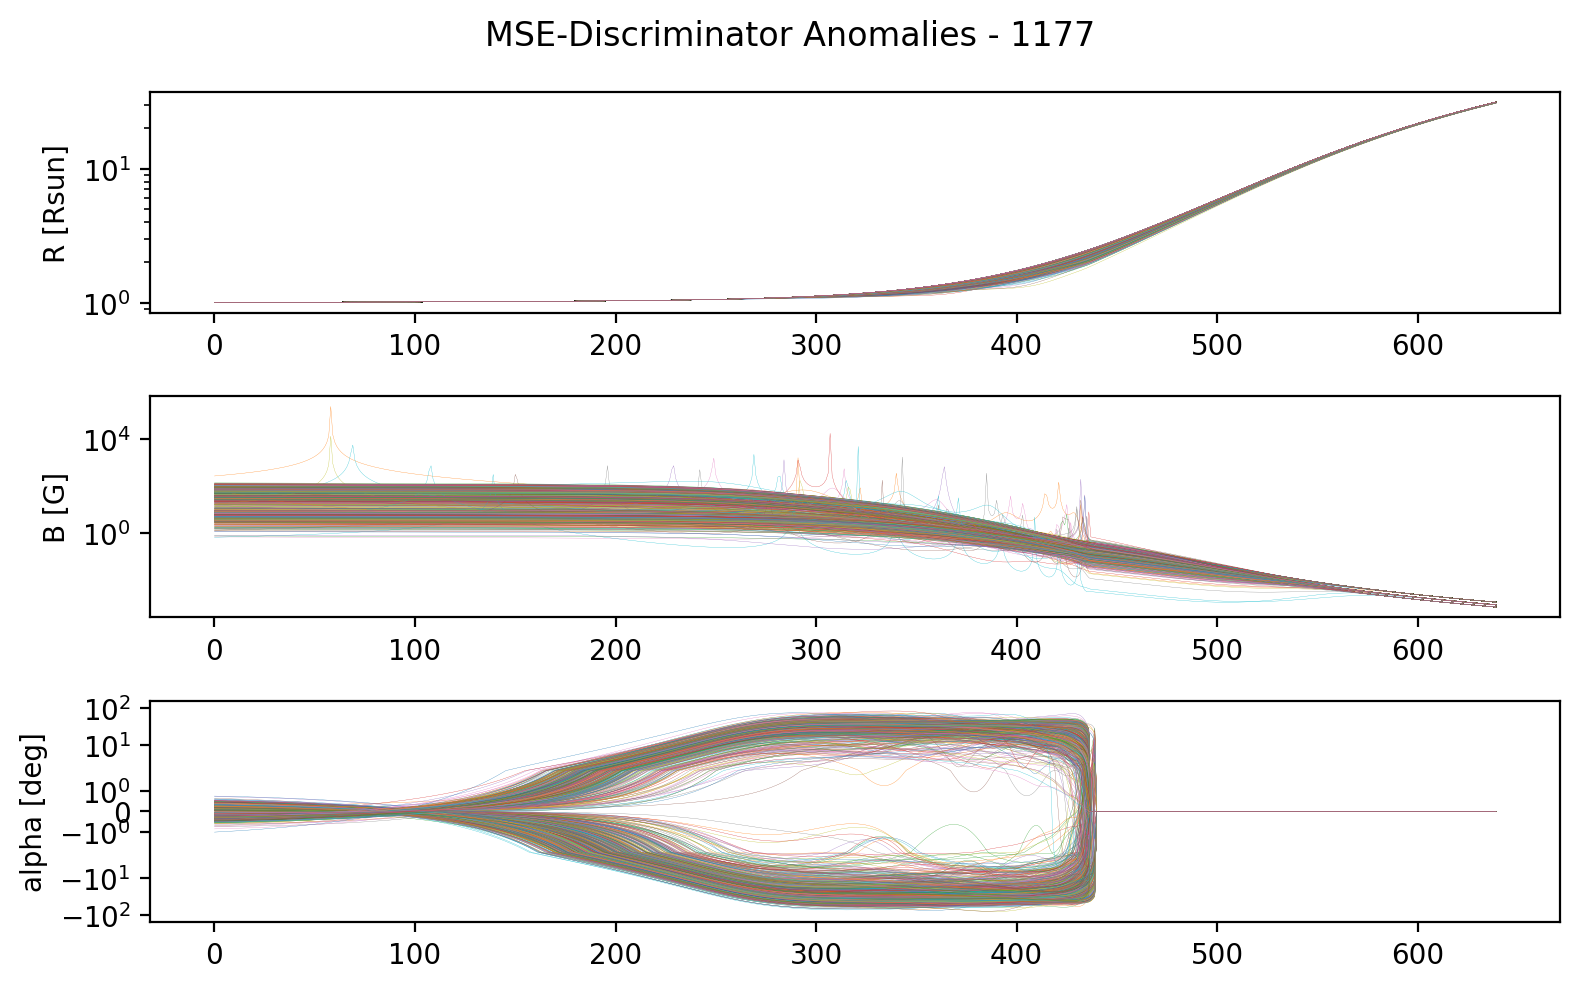

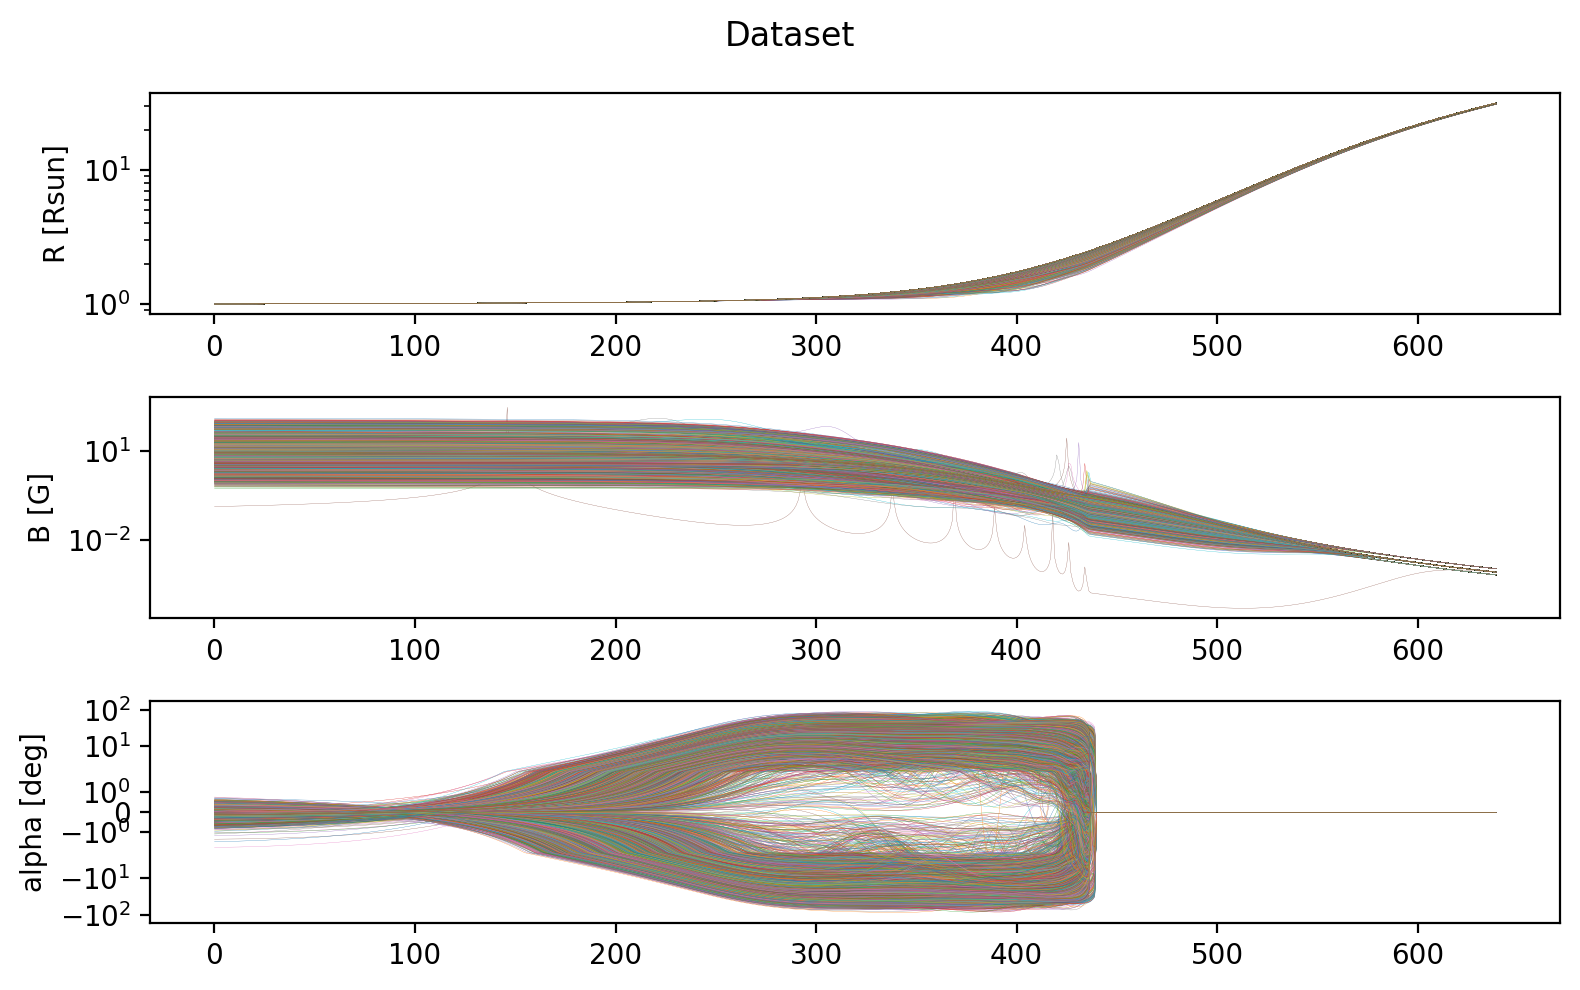

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", normal_plot=True)

### Feature Reconstruction

In [ ]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  4.6818454e-06
Found 1177 anomalies


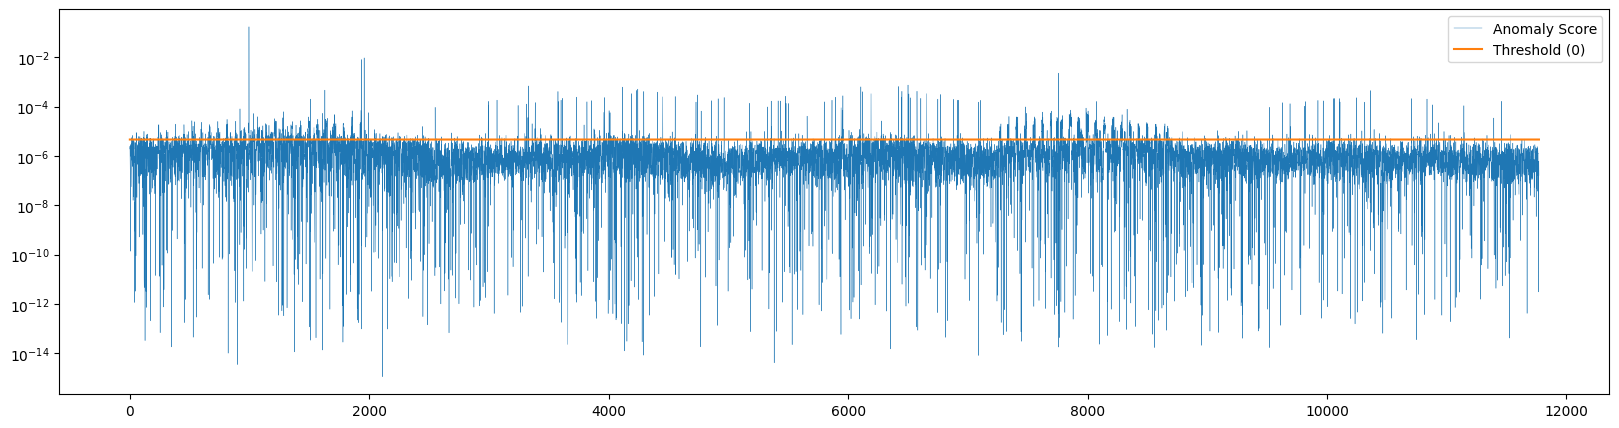

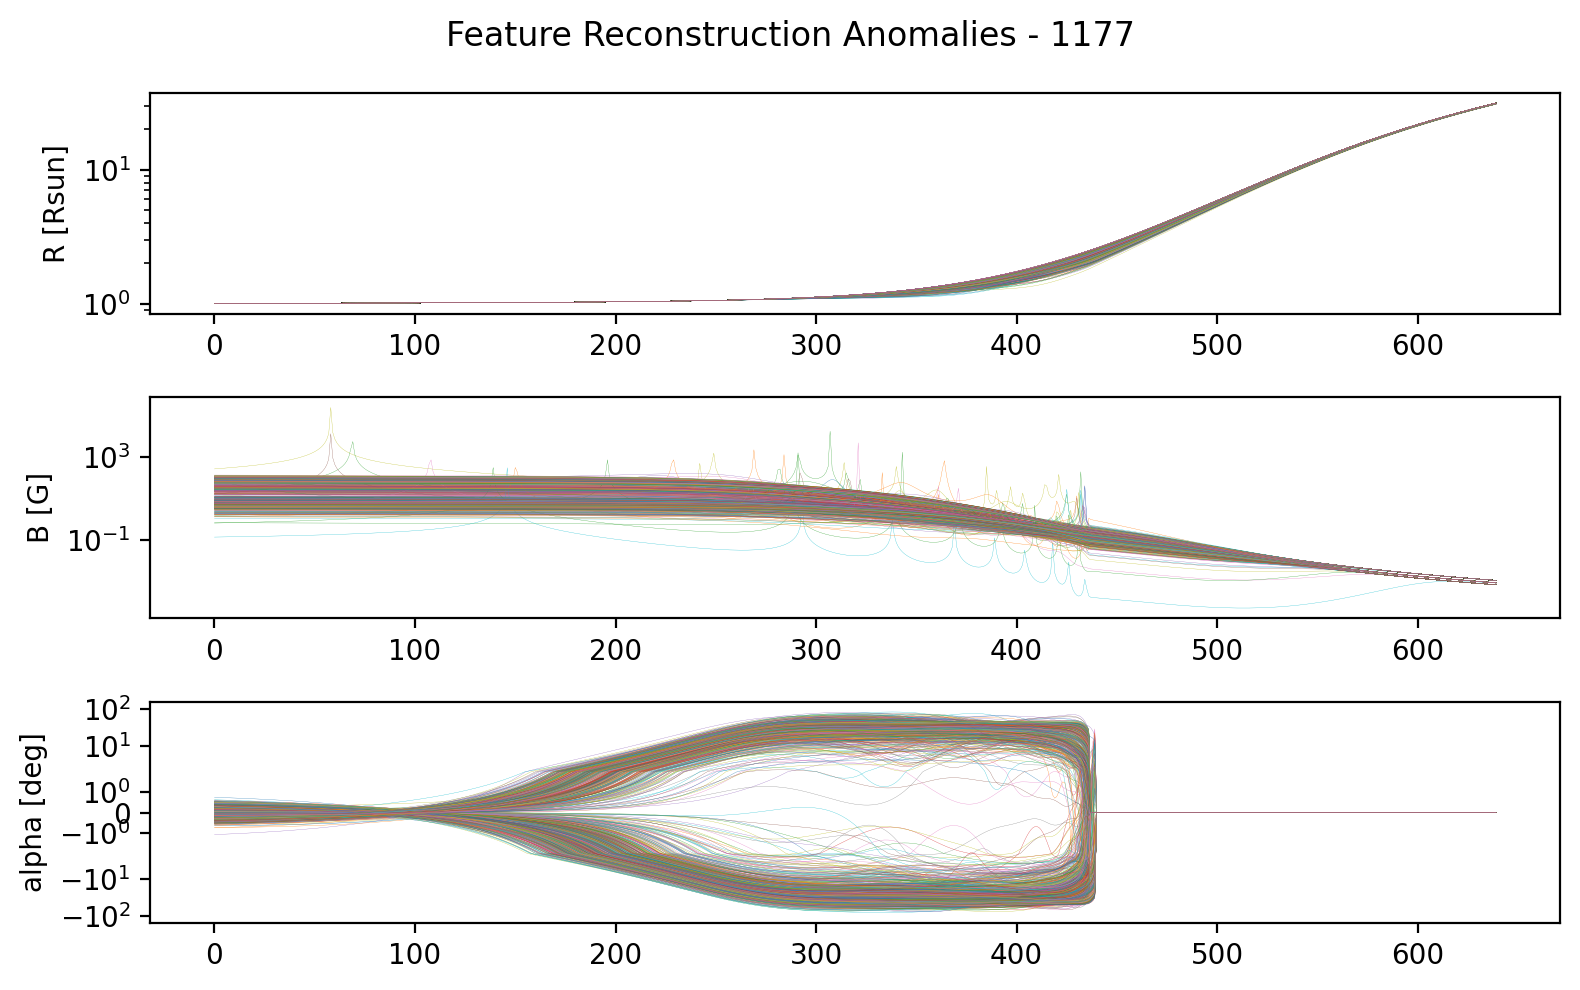

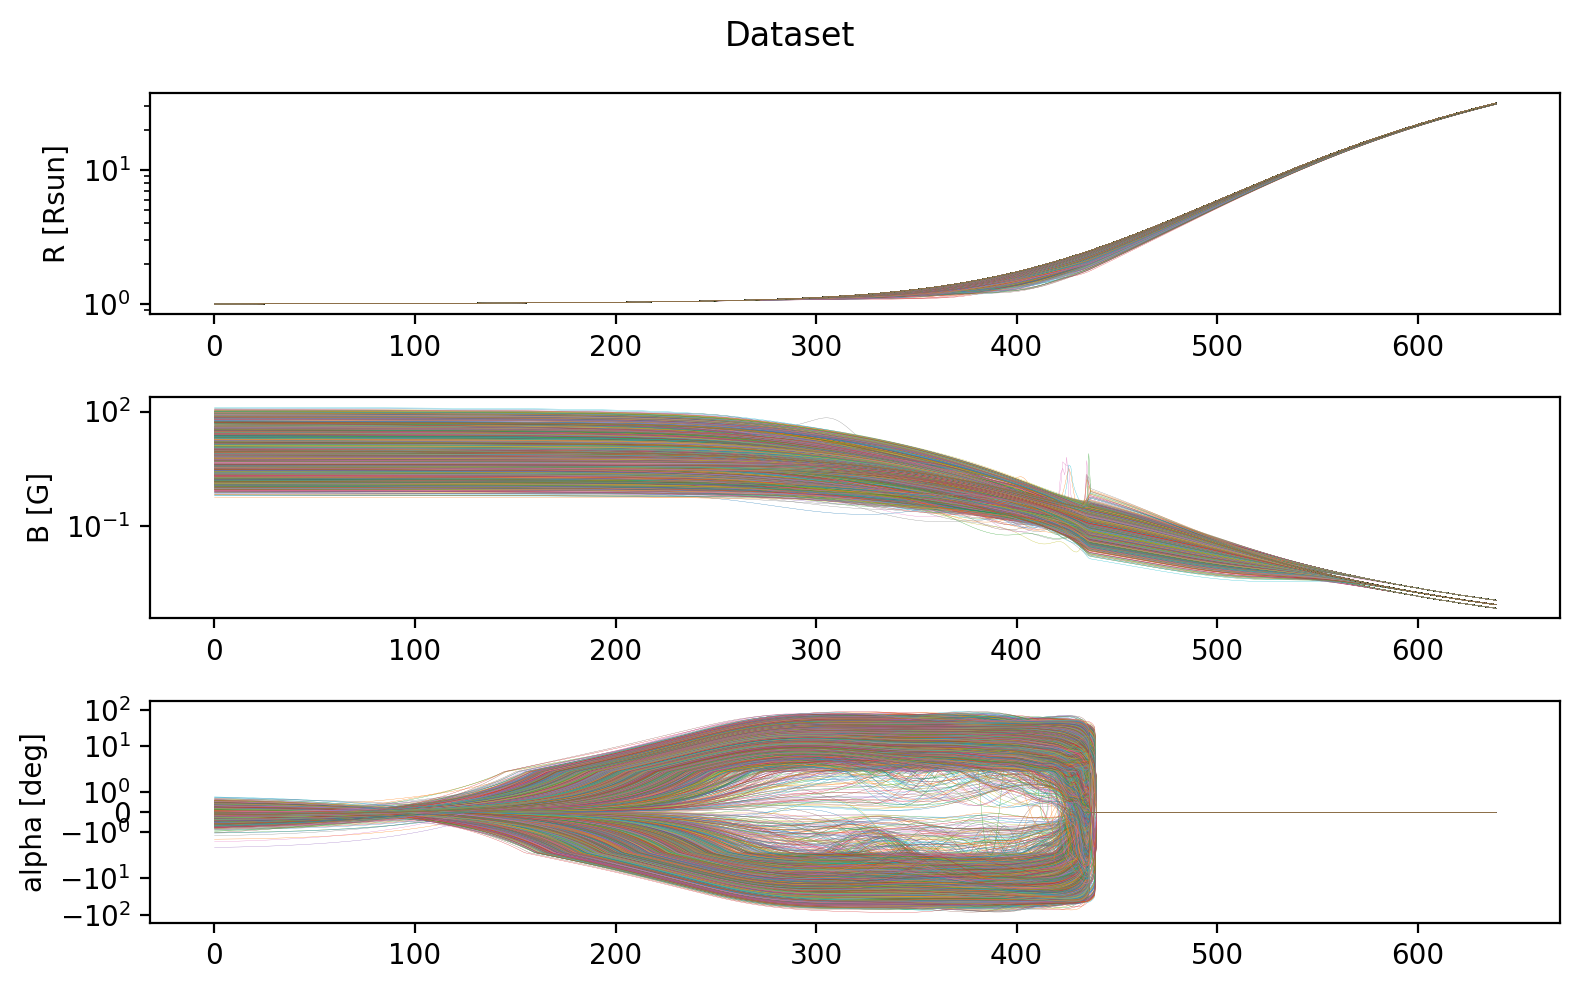

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature Reconstruction", normal_plot=True)